In [18]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import rioxarray
from shapely.geometry import mapping
import cftime
from datetime import datetime
import seaborn as sns




# Load data 

returns an xarray DataArray object with spatial metadata attached, enabling analysis and manipulation of raster data using xarray and rioxarray functions.

In [4]:
filepath=r"C:\Users\Admin\Documents\Data exploration\geospatial_test_datacube.nc"
dataset=xr.open_dataset(filepath)#Leverages the xarray library

In [5]:
print(dataset)


<xarray.Dataset>
Dimensions:   (time: 23, y: 227, x: 304)
Coordinates:
  * time      (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
  * y         (y) float32 45.23 45.23 45.23 45.23 ... 45.21 45.21 45.21 45.21
  * x         (x) float32 -69.95 -69.95 -69.95 -69.95 ... -69.92 -69.92 -69.92
Data variables:
    S2_RED    (time, y, x) float32 ...
    S2_GREEN  (time, y, x) float32 ...
    S2_BLUE   (time, y, x) float32 ...
    S2_NIR    (time, y, x) float32 ...
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.23320715]


In [ ]:
#dataset2= rioxarray.open_rasterio(filepath)#leverages the rasterio library
#print(dataset2.variables)    # Dictionary-like object with variable names and corresponding Variable objects
#print(dataset2.Dimensions)   # Dictionary-like object with dimension names and their sizes
#print(dataset2.attributes)   # Dictionary-like object with global file attributes


Understanding multi-dimensional arrays:an array of arrays
In a two-dimensional array, each element is a one-dimensional array. In a three-dimensional array, each element is a two-dimensional array, and so on.
In our example, we have a 3 dimensional array that represent a cube of numbers.For each point(lat,lon) in an image at time t, we have a pixel value for each band. But then we have 23 time steps hence a cube.
The data variables represent measurements in different spectral bands (e.g., red, green, blue, near-infrared), and the dimensions allow you to explore how these measurements change over time and across the area of interest. The coordinate values help you understand the specific locations and timestamps of each observation.

Select the last image and extract the red, green, blue bands

In [6]:
Image1=dataset.isel(time=-1)
R=Image1['S2_RED'].values
G=Image1['S2_GREEN'].values
B=Image1['S2_BLUE'].values

In [7]:
print(Image1)

<xarray.Dataset>
Dimensions:   (y: 227, x: 304)
Coordinates:
    time      datetime64[ns] 2021-11-25
  * y         (y) float32 45.23 45.23 45.23 45.23 ... 45.21 45.21 45.21 45.21
  * x         (x) float32 -69.95 -69.95 -69.95 -69.95 ... -69.92 -69.92 -69.92
Data variables:
    S2_RED    (y, x) float32 0.0175 0.0175 0.0252 ... 0.0137 0.0095 0.0164
    S2_GREEN  (y, x) float32 0.0145 0.0145 0.0174 ... 0.0167 0.0154 0.0171
    S2_BLUE   (y, x) float32 0.0034 0.0034 0.0065 0.0063 ... 0.0137 0.0034 0.007
    S2_NIR    (y, x) float32 ...
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.23320715]


stack the bands into an array the plot a coloured image:using numpy.dstack

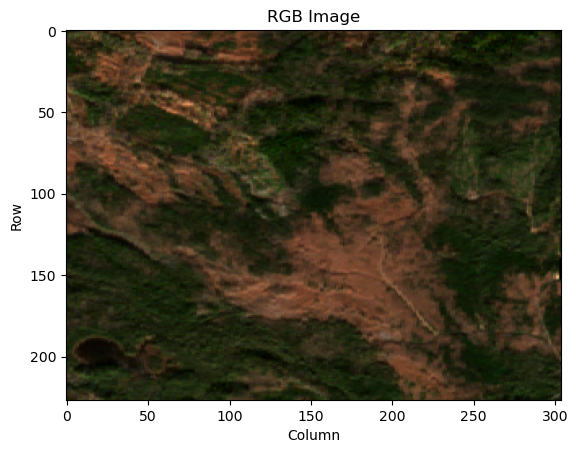

In [8]:
RGBImage = np.dstack((R,G,B))

#Improve image brightness using a linear scaling factor
RGBImage = (RGBImage - np.min(RGBImage)) / (np.max(RGBImage) - np.min(RGBImage))

plt.imshow(RGBImage)


plt.title("RGB Image")
plt.xlabel("Column")
plt.ylabel("Row")

plt.show()


In [9]:
dataset.crs

'+init=epsg:4326'

Select only the Red and NIR bands

In [10]:
dataset = dataset[['S2_RED','S2_NIR']]
print(dataset)

<xarray.Dataset>
Dimensions:  (time: 23, y: 227, x: 304)
Coordinates:
  * time     (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
  * y        (y) float32 45.23 45.23 45.23 45.23 ... 45.21 45.21 45.21 45.21
  * x        (x) float32 -69.95 -69.95 -69.95 -69.95 ... -69.92 -69.92 -69.92
Data variables:
    S2_RED   (time, y, x) float32 ...
    S2_NIR   (time, y, x) float32 ...
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.23320715]


Read the geojson file into a geodataframe. This is the area of interest to which we shall clip the images.

In [11]:


aoipath=r"C:\Users\Admin\Documents\Data exploration\geospatial_sub_aoi.geojson"
aoi=gpd.read_file(aoipath,crs="EPSG:4326")

In [12]:
aoi.head()

,geometry
0,"POLYGON ((-69.94867 45.23227, -69.94900 45.217..."


In [13]:
print(aoi.crs)

EPSG:4326


<Axes: >

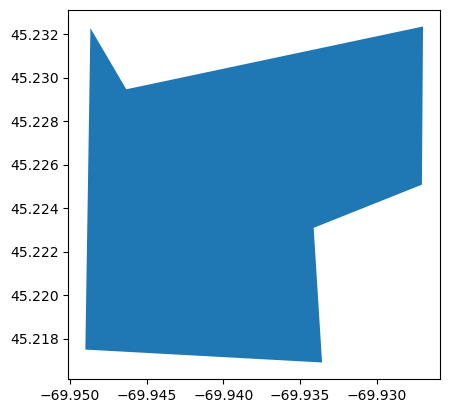

In [14]:
aoi.plot()

# Clip the images to AOI

Create a boolean mask from the aoi to using the shape and transform of the raster dataset.

In [19]:
clipped = dataset.rio.clip(aoi.geometry.apply(mapping), aoi.crs)

In [20]:
print(clipped)

<xarray.Dataset>
Dimensions:      (time: 23, y: 170, x: 245)
Coordinates:
  * time         (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
  * y            (y) float32 45.23 45.23 45.23 45.23 ... 45.22 45.22 45.22 45.22
  * x            (x) float32 -69.95 -69.95 -69.95 ... -69.93 -69.93 -69.93
    spatial_ref  int32 0
Data variables:
    S2_RED       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    S2_NIR       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.23320715]


# Explore the data

check and remove null values

In [21]:
variable_names = clipped['S2_RED'].values
print(variable_names)

[[[   nan    nan    nan ... 0.0372 0.0361 0.0303]
  [   nan    nan    nan ... 0.0584 0.0645 0.0378]
  [   nan    nan    nan ... 0.0402 0.0595 0.037 ]
  ...
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]]

 [[   nan    nan    nan ... 0.0312 0.0358 0.0326]
  [   nan    nan    nan ... 0.0347 0.0413 0.0314]
  [   nan    nan    nan ... 0.0358 0.0424 0.0318]
  ...
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]]

 [[   nan    nan    nan ... 0.0242 0.0283 0.0242]
  [   nan    nan    nan ... 0.0257 0.0347 0.0243]
  [   nan    nan    nan ... 0.0288 0.0337 0.0224]
  ...
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]
  [   nan    nan    nan ...    nan    nan    nan]]

 ...

 [[   nan    nan    nan ... 0.0249 0.0263 0.0228]
  [   nan    nan    

In [22]:
print(clipped.isnull())

<xarray.Dataset>
Dimensions:      (time: 23, y: 170, x: 245)
Coordinates:
  * time         (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
  * y            (y) float32 45.23 45.23 45.23 45.23 ... 45.22 45.22 45.22 45.22
  * x            (x) float32 -69.95 -69.95 -69.95 ... -69.93 -69.93 -69.93
    spatial_ref  int32 0
Data variables:
    S2_RED       (time, y, x) bool True True True True ... True True True True
    S2_NIR       (time, y, x) bool True True True True ... True True True True


new masked xarray dataset.

In [23]:
data = clipped.where(~dataset.isnull(), drop=True)
print(data)
#non_null_values = data.where(~data.isnull(), drop=True)

<xarray.Dataset>
Dimensions:      (time: 23, y: 170, x: 245)
Coordinates:
  * time         (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
  * y            (y) float32 45.23 45.23 45.23 45.23 ... 45.22 45.22 45.22 45.22
  * x            (x) float32 -69.95 -69.95 -69.95 ... -69.93 -69.93 -69.93
    spatial_ref  int32 0
Data variables:
    S2_RED       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    S2_NIR       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.23320715]


# Compute NDVI

define a function which takes the dataset, the red band and the NIR band as input then computes NDVI and creates a new variable in the dataset which stores the NDVI value.

In [24]:
def CalculateNDVI(dataset,redBand,nirBand):
    red=dataset[redBand]
    NIR=dataset[nirBand]
    NDVI = (NIR - red) / (NIR + red)
    
    # create new variable in the dataset
    dataset["S2_NDVI"] = NDVI
    dataset["S2_NDVI"].attrs = {
        "crs": "+init=epsg:4326",
        "descriptions": "Normalized Difference Vegetation Index"
    }
    
    return dataset


Call the function to the dataset by passing the dataset and the red and NIR bands

In [25]:
NDVIdataset = CalculateNDVI(data,"S2_RED","S2_NIR")
print(NDVIdataset)

<xarray.Dataset>
Dimensions:      (time: 23, y: 170, x: 245)
Coordinates:
  * time         (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
  * y            (y) float32 45.23 45.23 45.23 45.23 ... 45.22 45.22 45.22 45.22
  * x            (x) float32 -69.95 -69.95 -69.95 ... -69.93 -69.93 -69.93
    spatial_ref  int32 0
Data variables:
    S2_RED       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    S2_NIR       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    S2_NDVI      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    transform:        [ 8.98405270e-05  0.00000000e+00 -6.99499045e+01  0.000...
    crs:              +init=epsg:4326
    res:              [8.98405270e-05 9.04387077e-05]
    descriptions:     ['RED', 'GREEN', 'BLUE', 'NIR']
    AREA_OR_POINT:    Area
    _FillValue:       nan
    s2_data_lineage:  {"Data origin": "S3 bucket (ARN=arn:aws:s3:::sentinel-c...
    ulx, uly:         [-69.94990454  45.233207

# Visualize NDVI,NDVI Histogram and Timeseries

Plot NDVI histogram: The variable however has three dimensions, time, x and y hence the need to  flatten the array to only one dimension using the ravel() method from numpy.

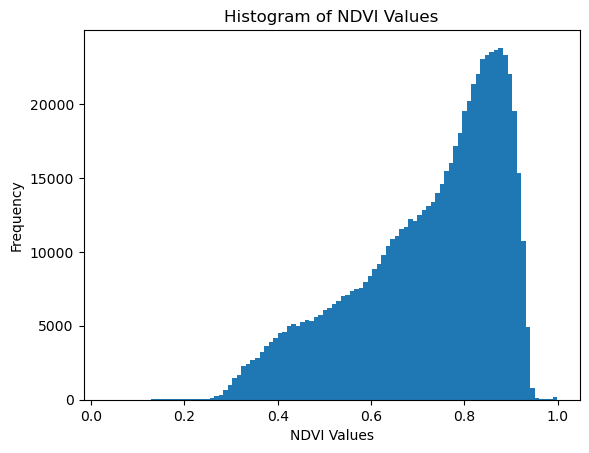

In [26]:
#ndvi values from the dataset
ndvi = data["S2_NDVI"].values.ravel()

# histogram of ndvi values
plt.hist(ndvi, bins=100)

# plot title and axis labels
plt.title("Histogram of NDVI Values")
plt.xlabel("NDVI Values")
plt.ylabel("Frequency")


plt.show()

Timeseries
AvgNDVI['time'] variable contains cftime objects instead of standard datetime objects. Matplotlib's plot function does not support cftime objects directly hence convert the cftime objects to standard datetime objects.

In [27]:
print(NDVIdataset["time"])

<xarray.DataArray 'time' (time: 23)>
array(['2021-04-09T00:00:00.000000000', '2021-04-14T00:00:00.000000000',
       '2021-04-27T00:00:00.000000000', '2021-05-07T00:00:00.000000000',
       '2021-05-19T00:00:00.000000000', '2021-05-24T00:00:00.000000000',
       '2021-05-29T00:00:00.000000000', '2021-06-18T00:00:00.000000000',
       '2021-07-28T00:00:00.000000000', '2021-08-10T00:00:00.000000000',
       '2021-08-12T00:00:00.000000000', '2021-08-25T00:00:00.000000000',
       '2021-09-04T00:00:00.000000000', '2021-09-16T00:00:00.000000000',
       '2021-09-19T00:00:00.000000000', '2021-09-21T00:00:00.000000000',
       '2021-10-06T00:00:00.000000000', '2021-10-09T00:00:00.000000000',
       '2021-10-29T00:00:00.000000000', '2021-11-05T00:00:00.000000000',
       '2021-11-20T00:00:00.000000000', '2021-11-23T00:00:00.000000000',
       '2021-11-25T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
    sp

In [28]:
NDVIdataset["time"]=NDVIdataset["time"].astype("datetime64[ns]")
print(NDVIdataset["time"])

<xarray.DataArray 'time' (time: 23)>
array(['2021-04-09T00:00:00.000000000', '2021-04-14T00:00:00.000000000',
       '2021-04-27T00:00:00.000000000', '2021-05-07T00:00:00.000000000',
       '2021-05-19T00:00:00.000000000', '2021-05-24T00:00:00.000000000',
       '2021-05-29T00:00:00.000000000', '2021-06-18T00:00:00.000000000',
       '2021-07-28T00:00:00.000000000', '2021-08-10T00:00:00.000000000',
       '2021-08-12T00:00:00.000000000', '2021-08-25T00:00:00.000000000',
       '2021-09-04T00:00:00.000000000', '2021-09-16T00:00:00.000000000',
       '2021-09-19T00:00:00.000000000', '2021-09-21T00:00:00.000000000',
       '2021-10-06T00:00:00.000000000', '2021-10-09T00:00:00.000000000',
       '2021-10-29T00:00:00.000000000', '2021-11-05T00:00:00.000000000',
       '2021-11-20T00:00:00.000000000', '2021-11-23T00:00:00.000000000',
       '2021-11-25T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2021-04-09 2021-04-14 ... 2021-11-25
    sp

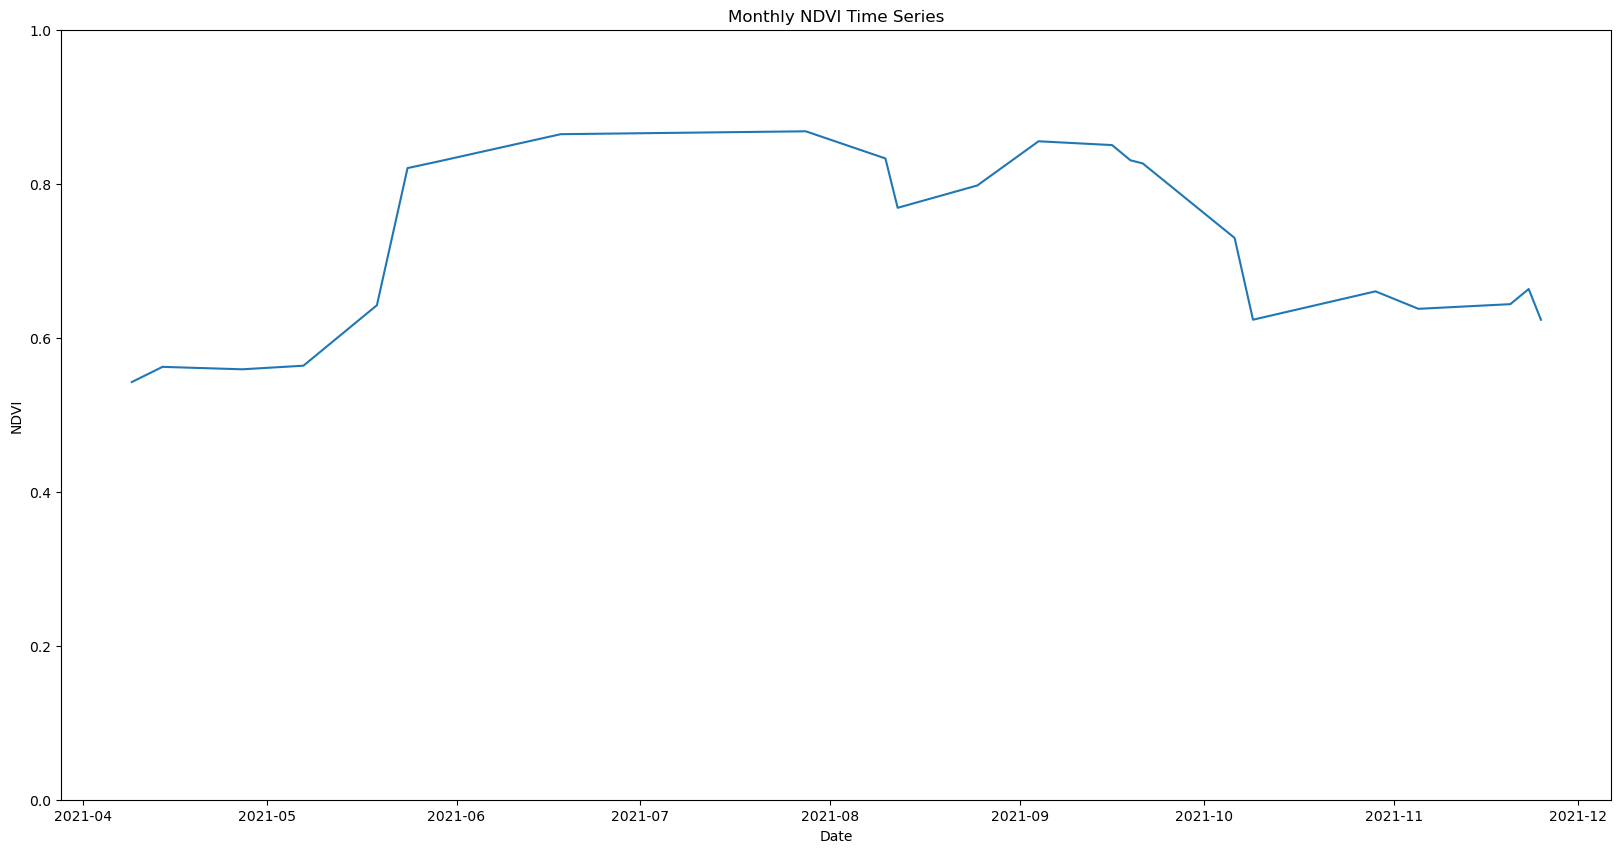

In [29]:


# Compute the mean NDVI value for each time step
AvgNDVI = NDVIdataset['S2_NDVI'].mean(dim=['y', 'x'])  #calculates the mean value along the 'y' and 'x' dimensions of the 'S2_NDVI' variable.
time=NDVIdataset["time"]#This variable will hold the time values associated with the NDVI data.


plt.figure(figsize=(20,10))

# Plot monthly NDVI as a time series
plt.plot(time, AvgNDVI)
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.ylim(0, 1)
# Set title
plt.title('Monthly NDVI Time Series')

# Show plot
plt.show()






From the dataset's corner coordinates  ulx, uly:[-69.94990454  45.23320715], it is noted that the NDVI values observed are from an area in North America which experiences four seasons. Between April and May is characterized by period of growth and rejuvenation of plants as weather gets warmer and as it transitions from Spring to Summer, NDVI values rise drastically.  Generally the summer time is characterized by precipitation, warmer weather and longer daylight hours hence vegetation thrive. However a small decrease is observed(early August) which could be attributed to temperatures being too high hence causing distress to vegetation. However NDVI values then rise again as a result of the transition from Summer to autumn which is characterized by cooler temperatures and high precipitation which rejuvenates the vegetation. As autumn progresses into winter, NDVI values once again drop as vegetation withers.

 visualize all NDVI values as an image with a color map using Matplotlib's imshow() function

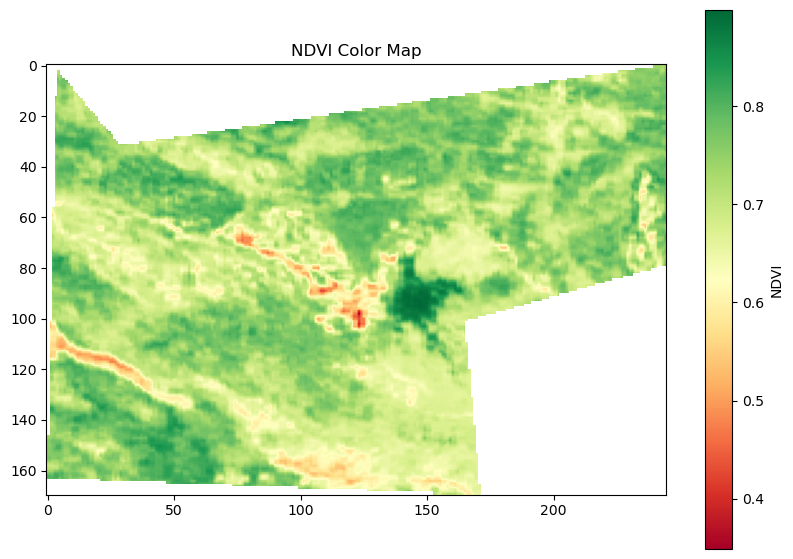

In [30]:
# Select all time steps of NDVI data
ndvi_all = NDVIdataset['S2_NDVI']

# Compute mean NDVI value for each pixel over all time steps
ndvi_mean = ndvi_all.mean(dim='time')



# Plot NDVI as a color map
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(ndvi_mean, cmap='RdYlGn')
ax.set_title('NDVI Color Map')


# Add color bar with label
cbar = fig.colorbar(im, ax=ax, shrink=0.7)
cbar.ax.set_ylabel('NDVI', rotation=90)
plt.show()


plt.close()



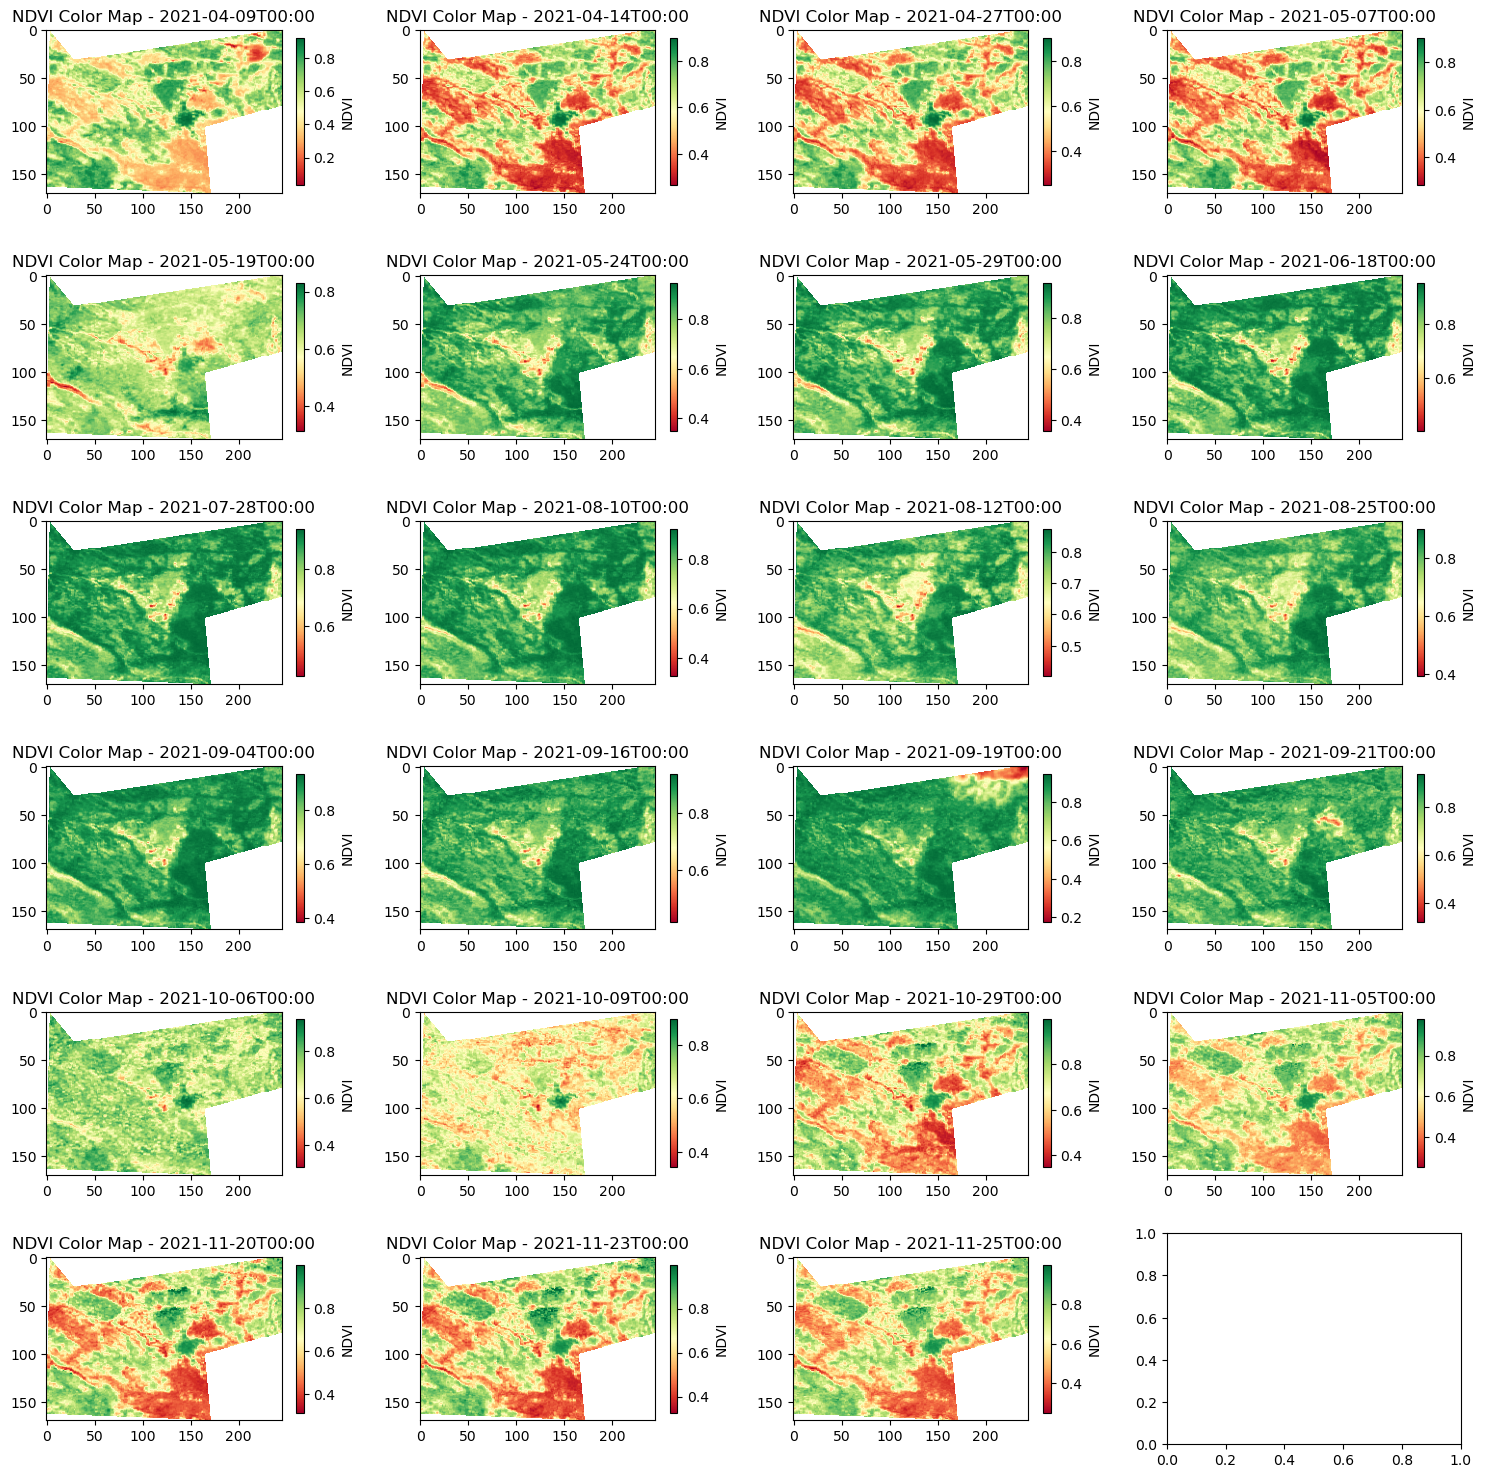

In [31]:

# Calculate the number of rows and columns for the subplots grid
num_plots = len(ndvi_all['time'])
num_cols = 4  # Number of columns in the grid
num_rows = (num_plots + num_cols - 1) // num_cols  # Compute the number of rows needed

# Loop over the time steps and create a plot for each month
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, t in enumerate(ndvi_all['time']):
    # Extract NDVI values for current month
    ndvi_t = ndvi_all.isel(time=i)

    # Convert time value to a regular date format
    formatted_date = np.datetime_as_string(t, unit='m')
    
    # Calculate the current row and column index for the subplot
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    # Plot NDVI as a color map in the corresponding subplot
    ax = axes[row_idx, col_idx]
    im = ax.imshow(ndvi_t, cmap='RdYlGn')
    ax.set_title(f'NDVI Color Map - {formatted_date}')
    
    # Add color bar with label
    cbar = fig.colorbar(im, ax=ax, shrink=0.7)
    cbar.ax.set_ylabel('NDVI', rotation=90)

# Adjust the spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()

# Save plots as PNG files to the current working folder
for i, t in enumerate(ndvi_all['time']):
    plt.figure(i)
    formatted_date = np.datetime_as_string(t.data, unit='m')
    plt.imshow(ndvi_all.isel(time=i), cmap='RdYlGn')
    plt.title(f'NDVI Color Map - {formatted_date}')
    plt.colorbar(label='NDVI')
    plt.savefig(f'ndvi_plots/ndvi_{i}.png')
    plt.close()
